### Regional glacier volume vs glacier area evolution

- at the top: glacier volume vs area
- at the bottom area res

In [36]:
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

In [82]:
from help_functions import pal_models, model_order, d_reg_num_name, model_order_anonymous,get_glob_temp_exp
pd_global_temp_exp = pd.read_csv('../data/climate_input_data/temp_ch_ipcc_ar6_isimip3b.csv', index_col = 0)

hue_order_anonymous = []

pal_models_l = []
hue_order = []
for m, p in zip(model_order, pal_models):
    if (m!='OGGM_v153') and (m!='Huss'): #m!='OGGM_v153'):
        hue_order.append(m)
        pal_models_l.append(p)
for m in hue_order:
    hue_order_anonymous.append(model_order_anonymous[m])
pal_models = pal_models_l

print(hue_order, hue_order_anonymous)
# select the right models:
pal_models = sns.color_palette(pal_models)

dict_model_col = {}
for c,m in zip(pal_models, hue_order):
    dict_model_col[m] = c
    
# select the right models

glac_models = hue_order

num_dict = {0:'(a)', 1:'(b)', 2:'(c)', 3:'(d)', 4: '(e)', 5:'(f)', 6:'(g)', 7:'(h)', 8:'(i)', 9:'(j)', 10:'(k)', 11:'(l)', 12:'(m)'} 

ind_t = pd_global_temp_exp.groupby(['gcm','period_scenario']).mean()['temp_ch_ipcc'].index
np.testing.assert_allclose(get_glob_temp_exp(region='global')['temp_ch_ipcc'].loc[ind_t].values,
                            pd_global_temp_exp.groupby(['gcm','period_scenario']).mean()['temp_ch_ipcc'].values, rtol=1e-5)
import matplotlib
matplotlib.__version__
pd_global_temp_exp_m = get_glob_temp_exp(region='global')


['PyGEM-OGGM_v13', 'GloGEMflow', 'GloGEMflow3D', 'OGGM_v16', 'GLIMB', 'Kraaijenbrink', 'GO', 'CISM2', 'OGGM-VAS'] ['model 1', 'model 2', 'model 3', 'model 4', 'model 5', 'model 6', 'model 7', 'model 8', 'model 10']


In [83]:
ds = xr.open_dataset('../data/GMIP3_reg_glacier_model_data/glacierMIP3_Feb12_2024_models_all_rgi_regions_sum_scaled_extended_repeat_last_101yrs.nc')

In [84]:
# quick check...
_count_models = ds.isel(simulation_year=1000).to_dataframe().dropna().groupby(['model_author']).count()
_count_models

simulation_year  volume_m3  area_m2  extend_option
model_author                                                      
CISM2                        80         80       80             80
GLIMB                      1520       1520     1520           1520
GO                           80         80       80             80
GloGEMflow                 1520       1520     1520           1520
GloGEMflow3D                880        880      880            880
Kraaijenbrink               240        240      240            240
OGGM-VAS                   1440       1440     1440           1440
OGGM_v153                   304        304      304            304
OGGM_v16                   1520       1520     1520           1520
PyGEM-OGGM_v13             1520       1520     1520           1520

In [85]:
glac_models

['PyGEM-OGGM_v13',
 'GloGEMflow',
 'GloGEMflow3D',
 'OGGM_v16',
 'GLIMB',
 'Kraaijenbrink',
 'GO',
 'CISM2',
 'OGGM-VAS']

In [86]:
ds = ds.sel(model_author=glac_models)

In [211]:
ds

<xarray.Dataset>
Dimensions:          (model_author: 9, simulation_year: 5001, gcm: 5,
                      rgi_reg: 19, period_scenario: 16)
Coordinates:
  * model_author     (model_author) <U14 'PyGEM-OGGM_v13' ... 'OGGM-VAS'
  * simulation_year  (simulation_year) int16 0 1 2 3 4 ... 4997 4998 4999 5000
  * gcm              (gcm) <U13 'gfdl-esm4' 'ipsl-cm6a-lr' ... 'ukesm1-0-ll'
  * rgi_reg          (rgi_reg) <U2 '01' '02' '03' '04' ... '16' '17' '18' '19'
  * period_scenario  (period_scenario) <U16 '1851-1870_hist' ... '2081-2100_s...
    extend_option    <U18 'repeat_last_101yrs'
Data variables:
    volume_m3        (model_author, gcm, rgi_reg, simulation_year, period_scenario) float32 ...
    area_m2          (model_author, gcm, rgi_reg, simulation_year, period_scenario) float32 ...
Attributes:
    description:           Scaled and extended regionally aggregated glacier ...
    postprocessing_phase:  Volume scaled to match regional Farinotti et al. (...
    dataset_version:       v1.0
    source:                Data from Glacier Model Intercomparison Project Ph...
    contact:               lilian.schuster@uibk.ac.at, harry.zekollari@vub.be

In [87]:
ds_stack = ds.stack(experiments=['gcm','period_scenario'])
ds_stack = ds_stack.assign_coords(temp_ch_ipcc = ('experiments',
                                                     pd_global_temp_exp_m.loc[ds_stack.experiments, # make sure thatwe use the same experiments
                                                                                             'temp_ch_ipcc']))
# need that to have bot volume_m3 and temp_ch_ipcc as variables
ds_stack = ds_stack.reset_coords()

## Let's compare the volume vs area for different time-steps and glacier models...

- https://agupubs.onlinelibrary.wiley.com/doi/10.1002/2014RG000470 

In [88]:
area = np.logspace(-1,3,50)

gamma=1.375
c = 0.03
def vol_area_scaling(area, c, gamma):
    vol= c*(area**gamma)
    return vol

In [89]:
len(hue_order)

9

In [119]:
pd_vas = pd.DataFrame(index=np.arange(0,500), 
                      columns=['model_author','rgi_reg', 'year','c', 'gamma','r2', 'pval'])

PyGEM-OGGM_v13 03 50 0.017243613327696052 1.2169472017233534 0.9714055992662907 [0.010417362861757873, 0.0]
GloGEMflow 03 50 0.6141856445916251 0.939449864158387 0.9099881052970886 [0.09800869276394941, 0.0]
PyGEM-OGGM_v13 04 50 0.0002984816907463285 1.5920582186804182 0.9776145778596401 [0.027317444570558624, 0.0]
GloGEMflow 14 50 2.0690066901523208e-05 1.8076011302909447 0.9469759650528431 [0.16575579718142608, 0.0]
GloGEMflow 03 100 0.016643546548647064 1.2408962154152907 0.936005137860775 [0.12013091140603516, 0.0]
OGGM-VAS 03 100 0.009092569718711252 1.2911703198598559 0.944097500294447 [0.029931086177279465, 0.0]
GloGEMflow 04 100 0.00010171093453946647 1.7123549250592462 0.9894617516547441 [0.013295441819479059, 0.0]
OGGM_v16 07 100 0.0001761711950963887 1.6788337181627282 0.9894829671829939 [0.010059697808692647, 0.0]
OGGM-VAS 07 100 1.1625308523234375e-05 1.938107877604183 0.9650802314281464 [0.20518981507128164, 0.0]
GloGEMflow 09 100 0.0011492404747730654 1.504831607820185 0

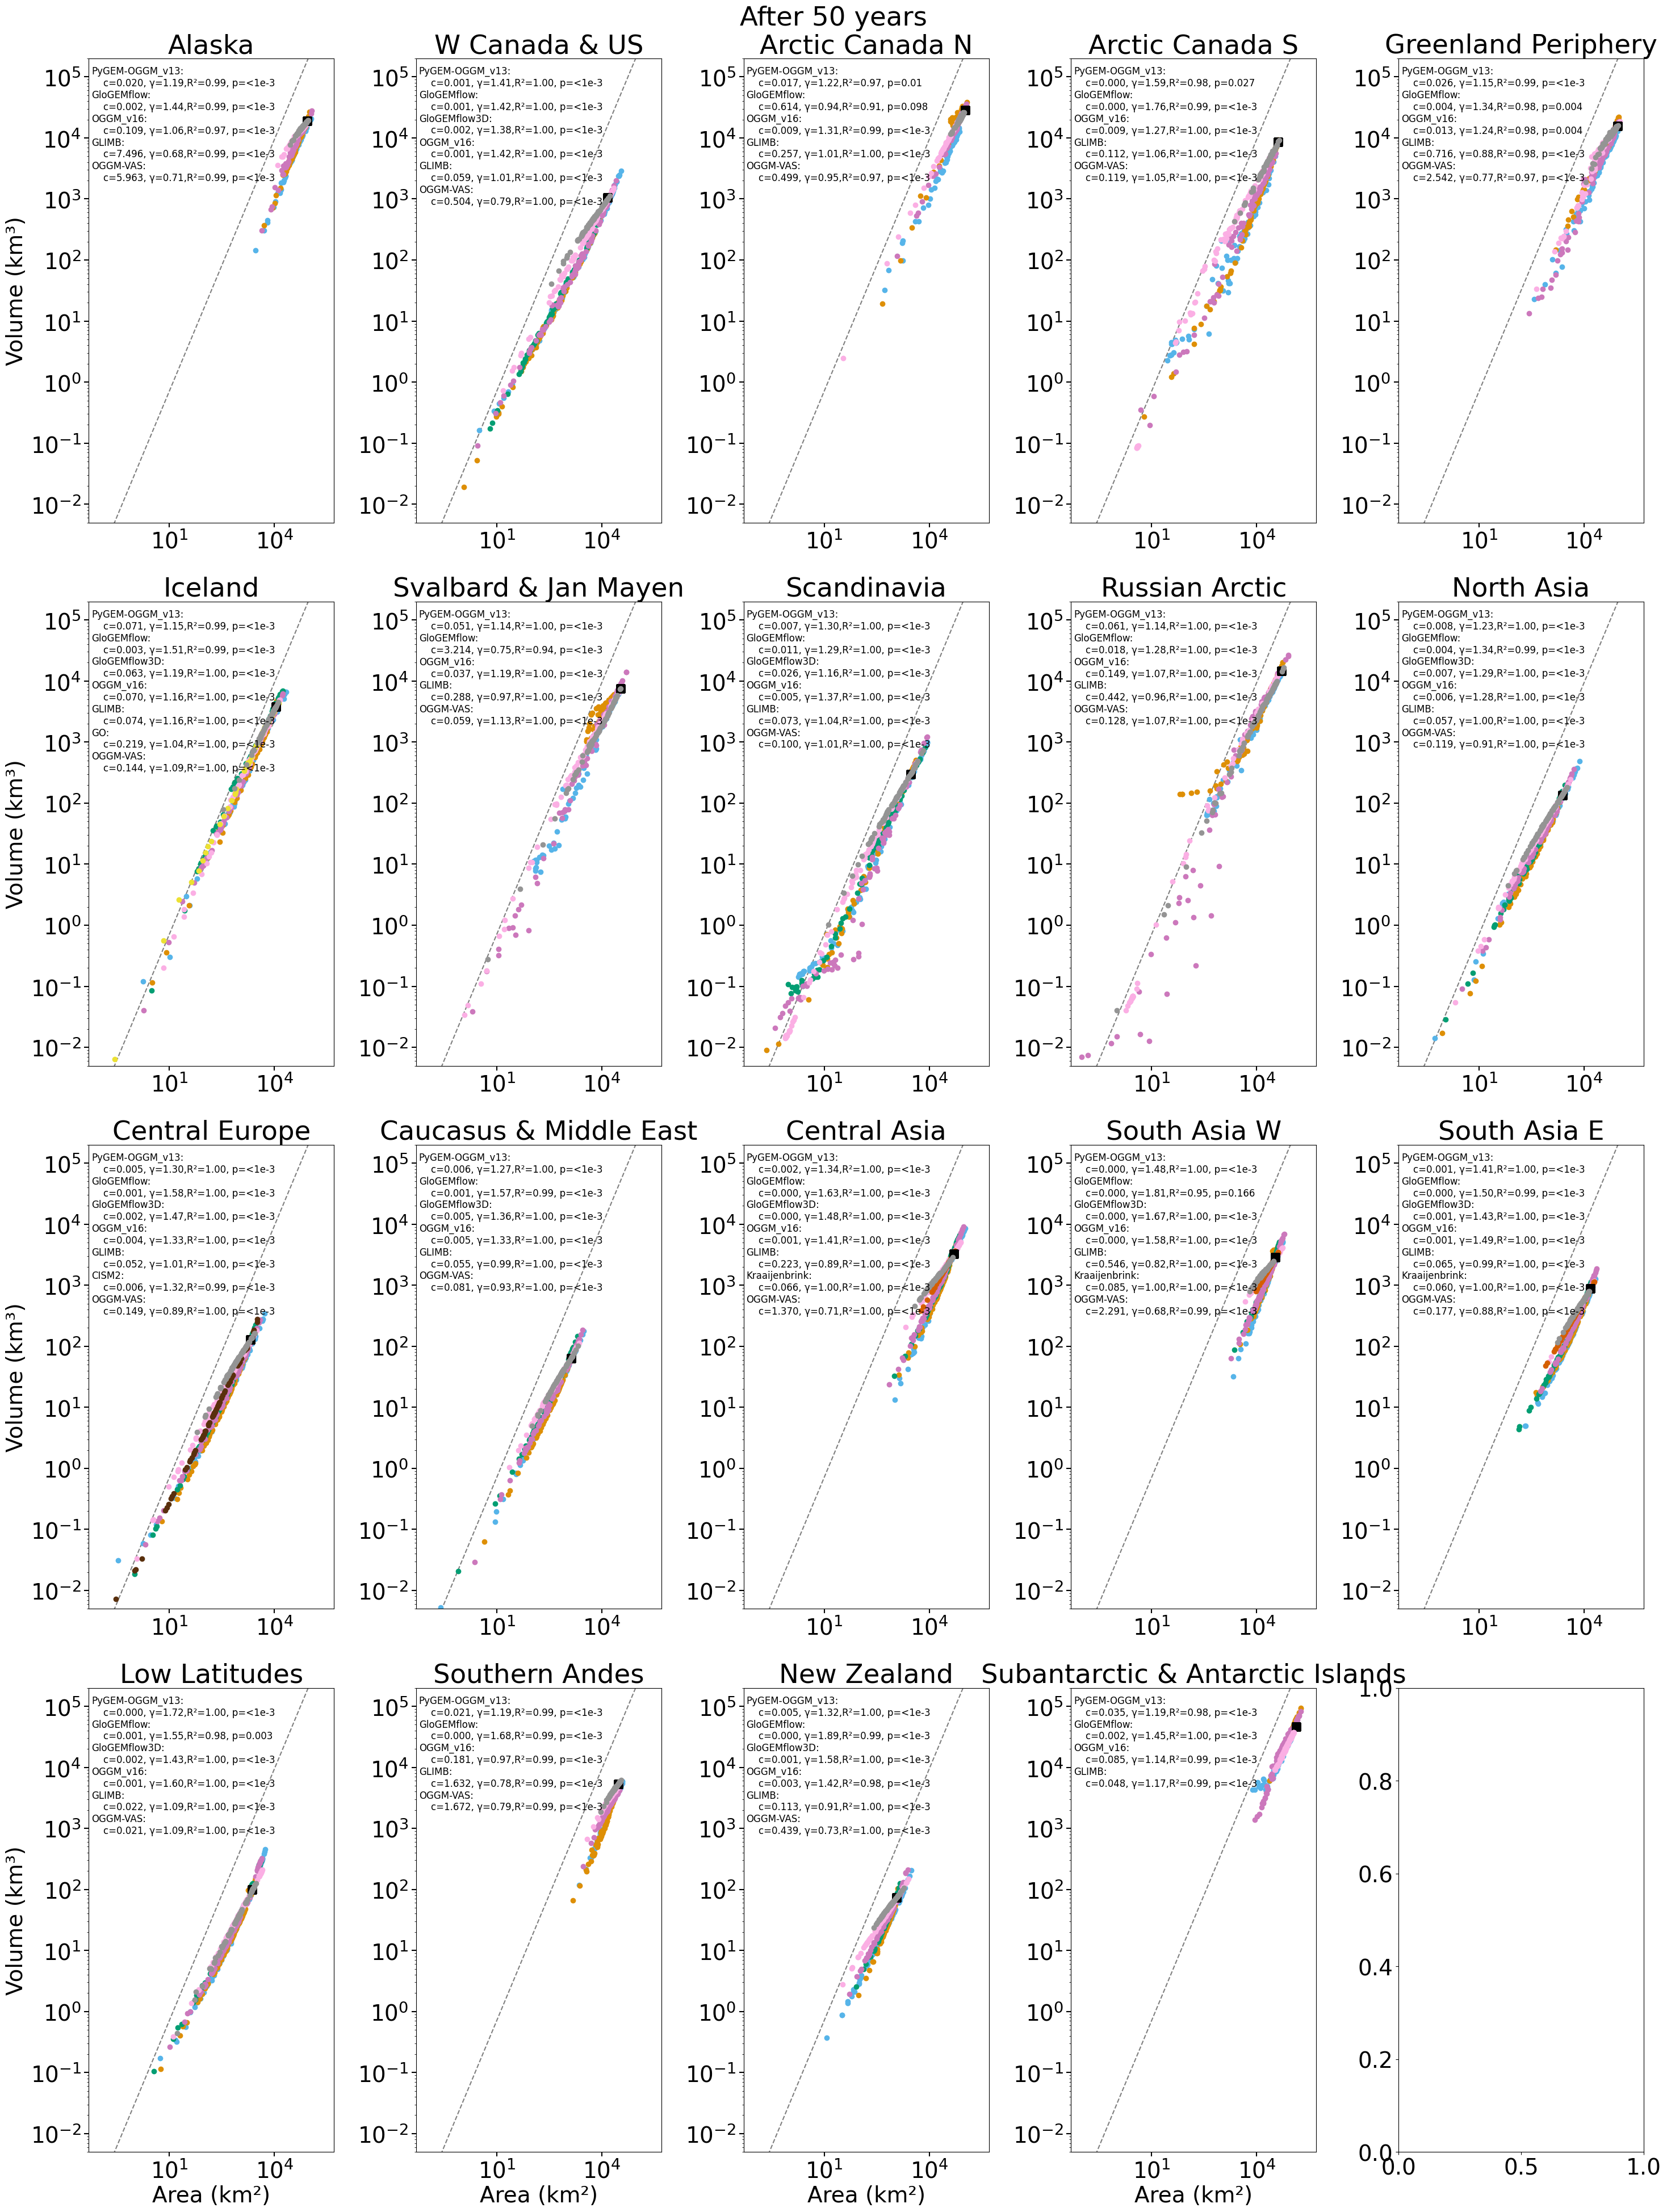

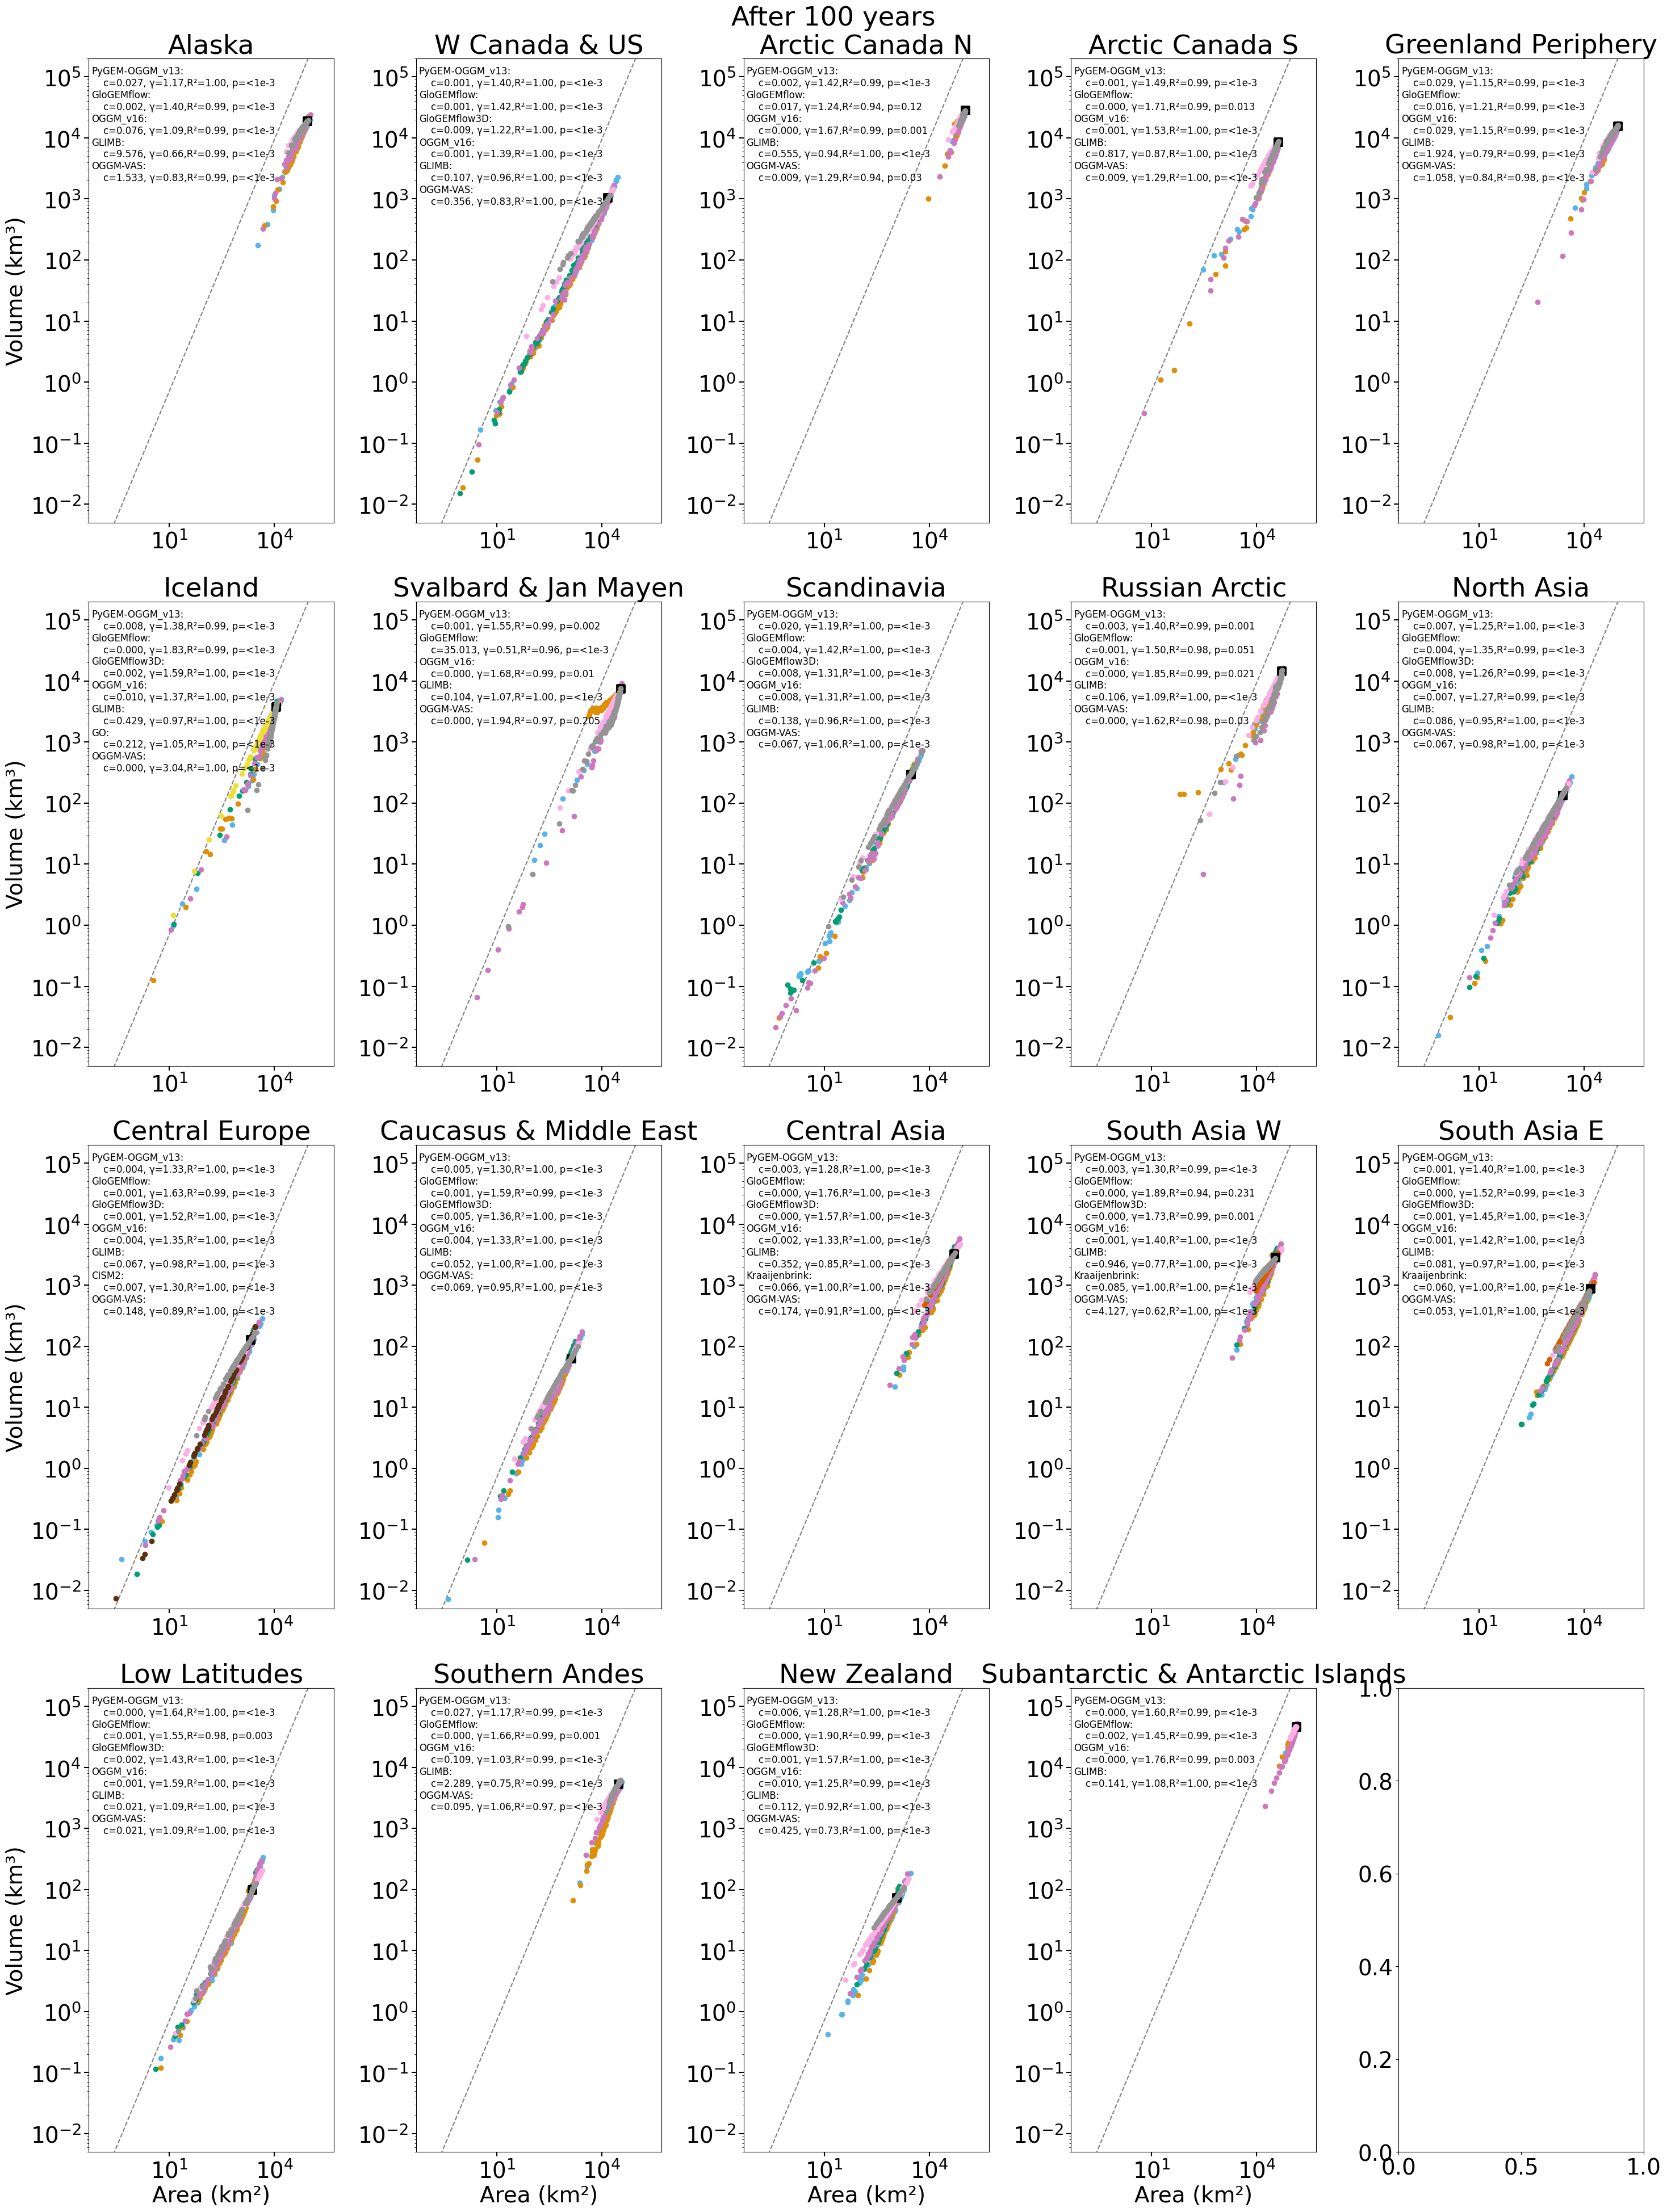

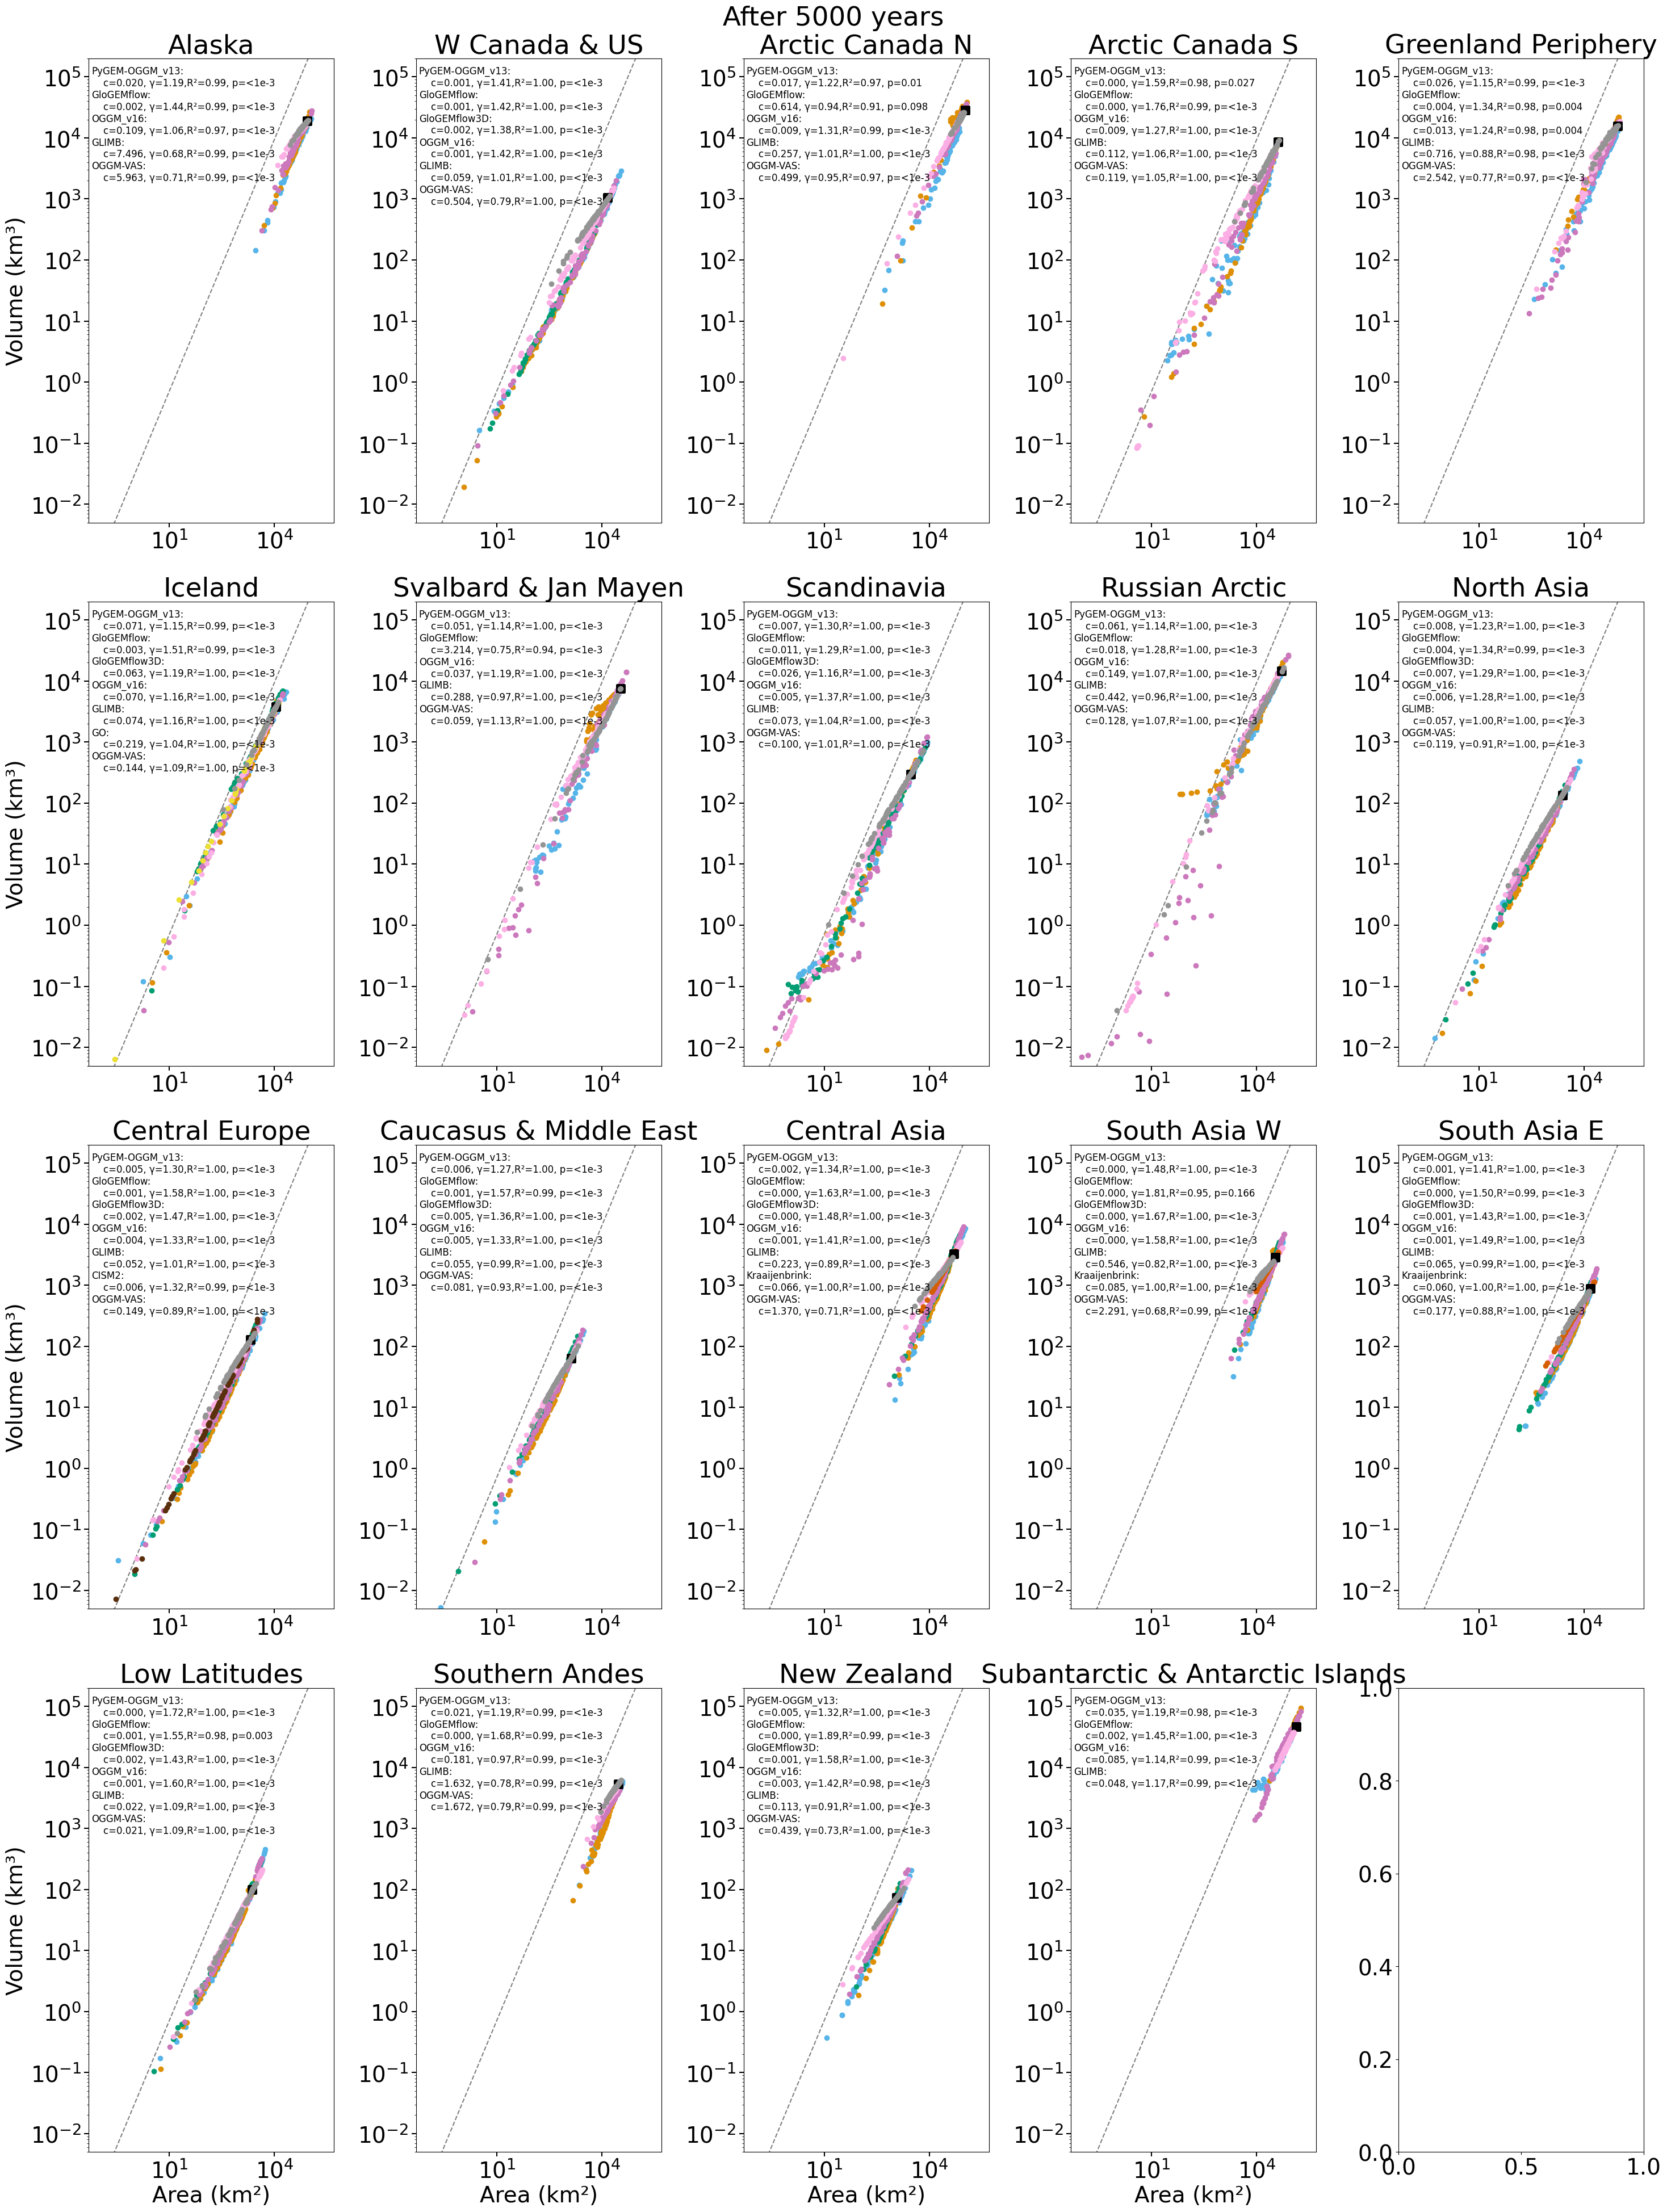

In [194]:
plt.rcParams['font.size'] = 28


area = np.logspace(-3, #int(np.floor(np.log10(_ds_area.min()/1e6))),
                   5.5, #int(np.floor(np.log10(_ds_area_init.max()/1e6))),
                   40)
jj = 0
for year in [50, 100, 5000]:
    fig, axs = plt.subplots(4,5,figsize=(30,40)) #, sharey=True, sharex=True)
    axs = axs.flatten()
    for j,reg in enumerate(d_reg_num_name.keys()):
        ax = axs[j]
        _ds_vol_init = ds_stack.sel(rgi_reg=reg).volume_m3.isel(simulation_year=0)
        _ds_area_init = ds_stack.sel(rgi_reg=reg).area_m2.isel(simulation_year=0)
        ax.loglog(area, vol_area_scaling(area, c, gamma), color='gray', ls= '--')

        if year == 100: 
            text = ''
            _ds_vol = ds_stack.sel(rgi_reg=reg).volume_m3.isel(simulation_year=slice(90,110)).mean(dim='simulation_year')
            _ds_area = ds_stack.sel(rgi_reg=reg).area_m2.isel(simulation_year=slice(90,110)).mean(dim='simulation_year')
        elif year == 30:
            text = ''
            _ds_vol = ds_stack.sel(rgi_reg=reg).volume_m3.isel(simulation_year=slice(20,40)).mean(dim='simulation_year')
            _ds_area = ds_stack.sel(rgi_reg=reg).area_m2.isel(simulation_year=slice(20,40)).mean(dim='simulation_year')
        else:
            text = ''
            _ds_vol = ds_stack.sel(rgi_reg=reg).volume_m3.isel(simulation_year=slice(-101,-1)).mean(dim='simulation_year')
            _ds_area = ds_stack.sel(rgi_reg=reg).area_m2.isel(simulation_year=slice(-101,-1)).mean(dim='simulation_year')

        for m in dict_model_col.keys():
            col = dict_model_col[m]
            # this is by definition everywhere the same
            ax.loglog(_ds_area_init.sel(model_author=m)/1e6,
                      _ds_vol_init.sel(model_author=m)/1e9, 's', ms=10,
                      color='black', alpha = 0.5)
        
            #ax.loglog(_ds_area_100.sel(model_author=m)/1e6, _ds_vol_100.sel(model_author=m)/1e9, 's', color=col)
            area_values = (_ds_area.sel(model_author=m)/1e6).values.flatten()
            volume_values = (_ds_vol.sel(model_author=m)/1e9).values.flatten()
            mask = ~np.isnan(area_values) & ~np.isnan(volume_values)
            area_values = area_values[mask]
            volume_values = volume_values[mask]
            
            if not np.all(np.isnan(area_values)):
                # go to next model...
                #continue
                # Fit the scaling function to the data
                popt, pcov = curve_fit(vol_area_scaling, area_values, 
                                       volume_values)#, p0=[1, 1])
                
                # Extract the fitted parameters
                c_fit, gamma_fit = popt
                # compute error
                perr = np.sqrt(np.diag(pcov))
        
                # calculate R2 values... 
                predicted_volume = vol_area_scaling(area_values, *popt)
                residuals = volume_values - predicted_volume
                ss_res = np.sum(residuals**2)
                ss_tot = np.sum((volume_values - np.mean(volume_values))**2)
                r_squared = 1 - (ss_res / ss_tot)
        
                
                # Calculate p-values
                from scipy.stats import t
                dof = len(volume_values) - len(popt)  # Degrees of freedom
                t_stats = popt / perr
                p_values = [2 * (1 - t.cdf(np.abs(t_stat), dof)) for t_stat in t_stats]
                for p in p_values:
                    if p>0.01:
                        print(m, reg, year, c_fit, gamma_fit, r_squared, p_values)
                if p_values[0].round(3)<0.001:
                    p_t = '<1e-3'
                else:
                    p_t = p_values[0].round(3)
                # Print the fitted parameters
                text = text + f"{m}:\n    "+f"c={c_fit.round(3):.3f}, γ={gamma_fit.round(2):.2f},"
                text = text + f"R²={r_squared:.2f}, p={p_t}\n"
                ax.loglog(area_values, volume_values, 'o', color=col)
                _vas_vals = [m, reg, year, c_fit, gamma_fit, r_squared, p_values[0]]
            else:
                _vas_vals = [m, reg, year, np.NaN, np.NaN, np.NaN, np.NaN]
            pd_vas.loc[jj, ['model_author', 'rgi_reg', 
                            'year','c', 'gamma','r2', 'pval']] = _vas_vals
            jj+=1
        if j in np.arange(0,21,5):
            ax.set_ylabel('Volume (km³)')
        else:
            ax.set_ylabel('')
        if j in np.arange(15,21,1):
            ax.set_xlabel('Area (km²)')
        else:
            ax.set_xlabel('')
        ax.text(6e-2, 1.5e5, text, fontsize=12, va='top', ha='left')
        ax.set_title(d_reg_num_name[reg])
        ax.set_ylim(5e-3,2e5)
        ax.set_xlim(5e-2, 5e5)
        ax.tick_params(axis='both', 
                   width=1.5,  
                   length=6)    
    plt.suptitle(f'After {year} years')
    plt.tight_layout()
    plt.savefig(f'partB_4_volume_vs_area_steady_state_years{year}.pdf')

In [197]:
pd_vas.c.quantile(0.1)

0.0003077426790476265

In [ ]:
pd_vas = pd_vas.dropna(how='any')

In [190]:
pd_vas

model_author rgi_reg  year         c     gamma        r2      pval
0    PyGEM-OGGM_v13      01    50  0.020381   1.19372  0.994505       0.0
1        GloGEMflow      01    50   0.00165  1.436355  0.990557  0.000005
3          OGGM_v16      01    50  0.109069  1.060634  0.973483  0.000176
4             GLIMB      01    50  7.496441  0.683857  0.991572       0.0
8          OGGM-VAS      01    50  5.962623  0.709678  0.986746       0.0
..              ...     ...   ...       ...       ...       ...       ...
508           GLIMB      19  5000  0.048274  1.166099   0.99493       0.0
509   Kraaijenbrink      19  5000       NaN       NaN       NaN       NaN
510              GO      19  5000       NaN       NaN       NaN       NaN
511           CISM2      19  5000       NaN       NaN       NaN       NaN
512        OGGM-VAS      19  5000       NaN       NaN       NaN       NaN

[513 rows x 7 columns]

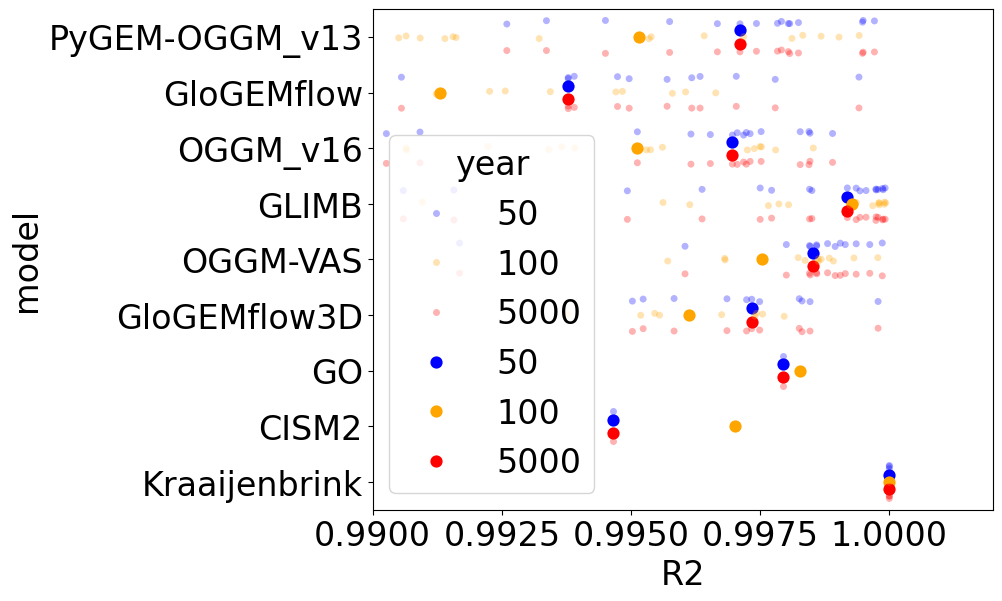

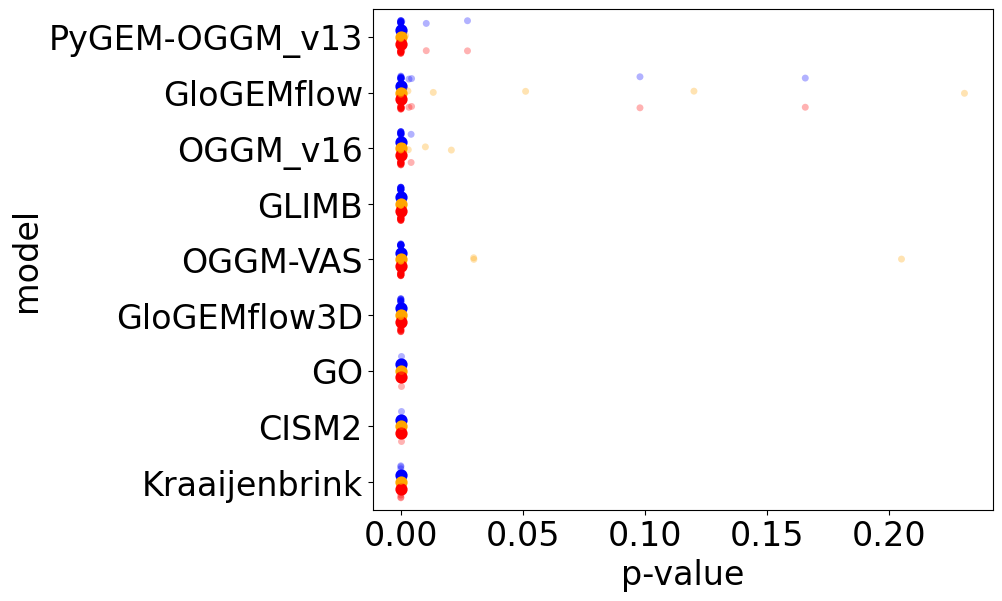

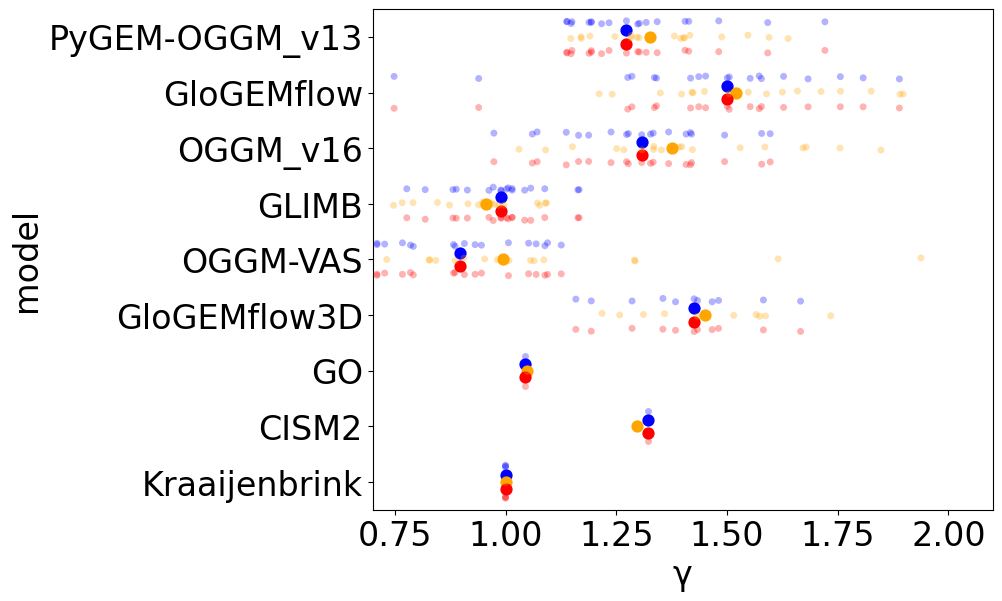

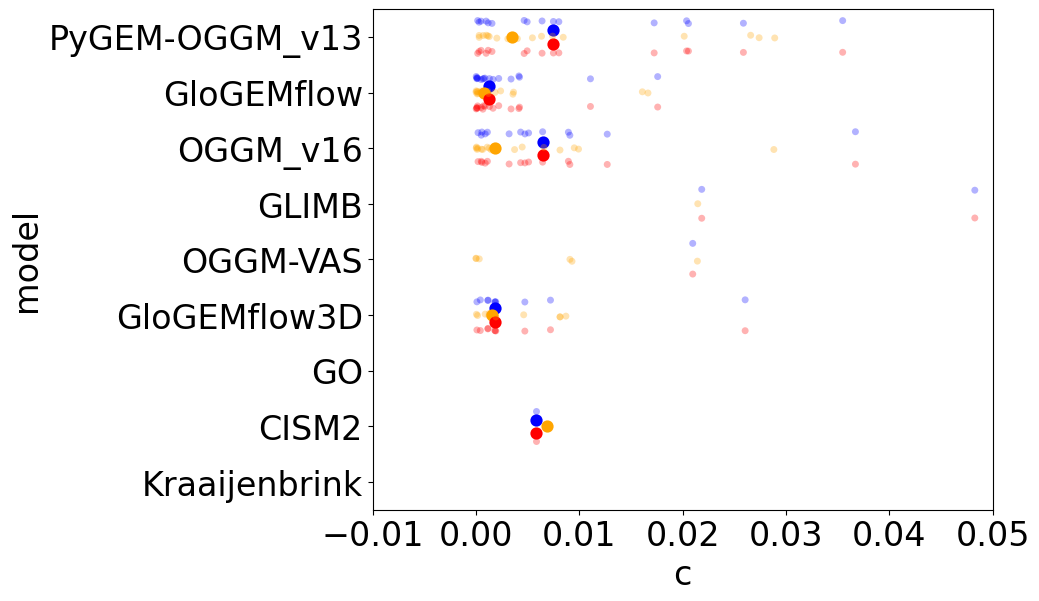

In [203]:
plt.rc('font', size=24)  
#plt.figure(figsize=(29.5,12.5)) #, sharey=True)
dict_x ={}
dict_x['r2'] = 'R2'
dict_x['pval'] = 'p-value'
dict_x['gamma'] = 'γ'
dict_x['c'] = 'c'

for x in ['r2', 'pval','gamma','c']:
    plt.figure(figsize=(8,6.5))
    ax=plt.gca()
    sns.stripplot(data=pd_vas, hue='year', x=x, y='model_author',
                    #fliersize=0, whis = [5,95], 
                    #dodge = True, #hue='ssp',
                    palette=sns.color_palette(['blue','orange','red']),
                          #order = list(_sel_class1_sorted.rgi_reg_long.values), # order after -0.1 to 2.0°C 
                    #y = 'time', #hue_order = ['2040', '2100'],
                    #linewidth=2,
                    #capprops={'color':'grey', 'alpha':0.7},
                    #whiskerprops={'color':'grey', 'alpha':0.7},
                    #medianprops={'color':'black'},
                  dodge=True,
                  alpha=0.3,
                 ax=ax)
    sns.pointplot(estimator='median', 
                  data=pd_vas, hue='year', x=x, y='model_author',
                  markers=['o','o','o'],
                  linestyle="none",
                  dodge=0.24,
                  errorbar=None,
                    palette=sns.color_palette(['blue','orange','red']),
                #saturation = 0.9,
                 ax=ax)
               #hue_order=hue_order, palette=pal_models, ax=ax)
    if x=='r2':
        ax.set_xlim([0.93,1.002])
    elif x=='c':
        ax.set_xlim([-0.005, 3])
    elif x=='gamma':
        ax.set_xlim([0.7, 2.1])
    ax.set_ylabel('model')
    ax.set_xlabel(dict_x[x])
    if x!= 'r2':
        ax.get_legend().remove()

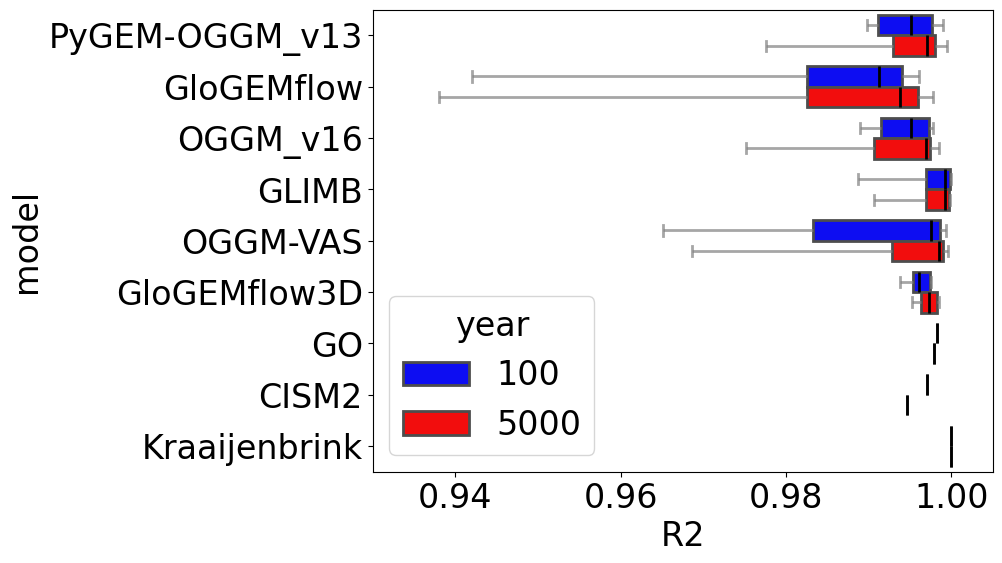

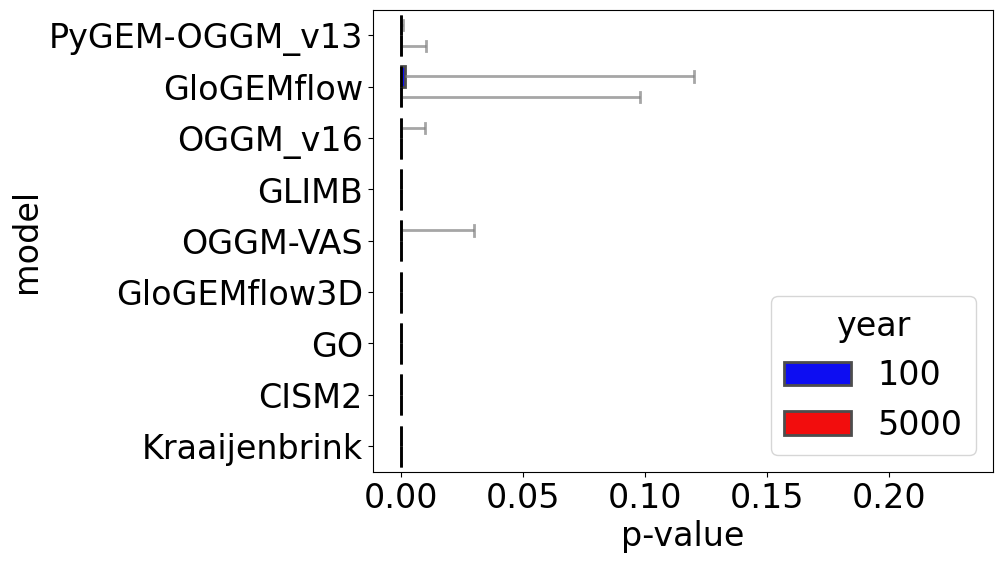

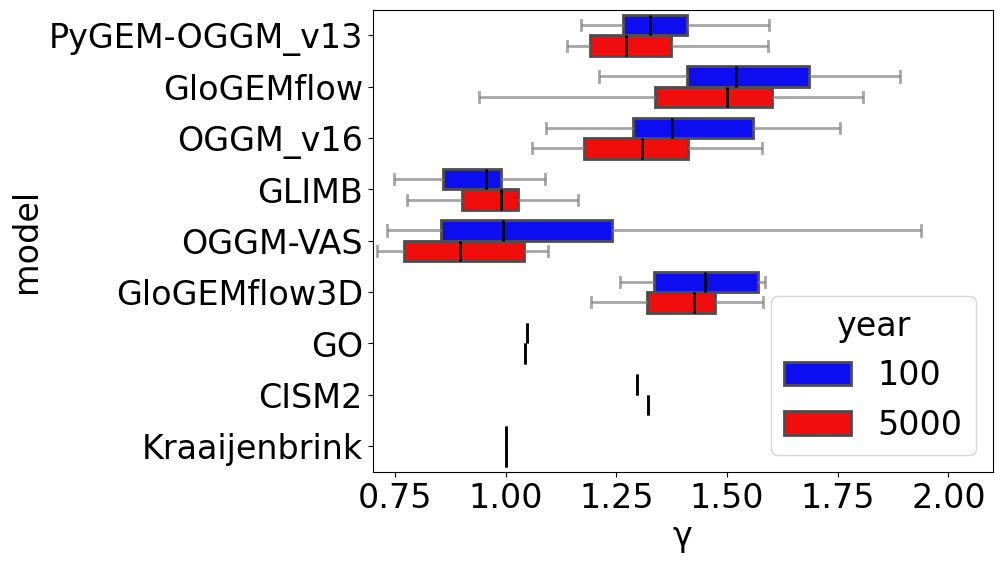

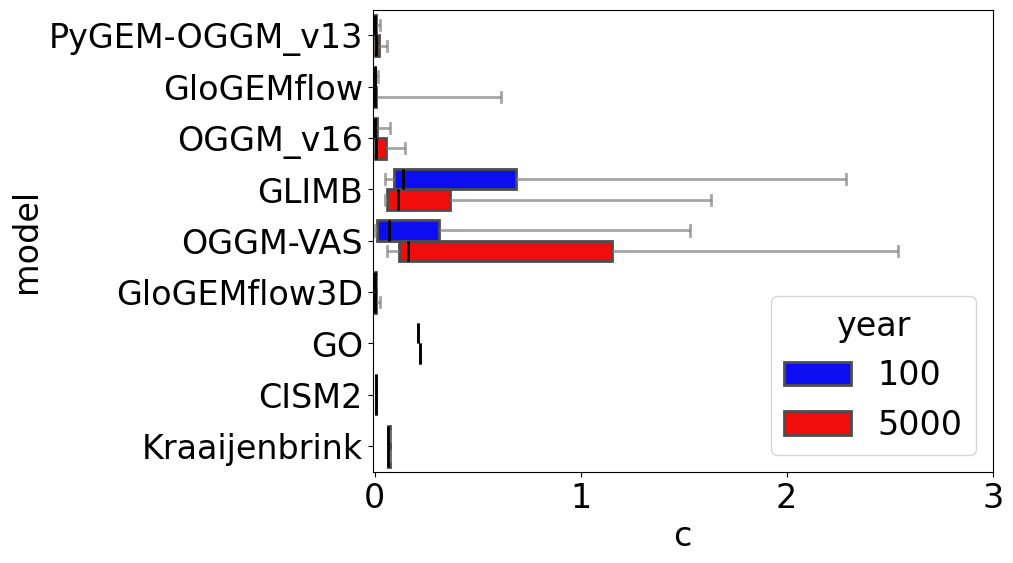

In [169]:
plt.rc('font', size=24)  
#plt.figure(figsize=(29.5,12.5)) #, sharey=True)
dict_x ={}
dict_x['r2'] = 'R2'
dict_x['pval'] = 'p-value'
dict_x['gamma'] = 'γ'
dict_x['c'] = 'c'

for x in ['r2', 'pval','gamma','c']:
    plt.figure(figsize=(8,6))
    ax=plt.gca()
    sns.boxplot(data=pd_vas, hue='year', x=x, y='model_author',
                    fliersize=0, whis = [5,95], 
                    dodge = True, #hue='ssp',
                    palette=sns.color_palette(['blue','red']),
                          #order = list(_sel_class1_sorted.rgi_reg_long.values), # order after -0.1 to 2.0°C 
                    #y = 'time', #hue_order = ['2040', '2100'],
                    linewidth=2,
                    capprops={'color':'grey', 'alpha':0.7},
                    whiskerprops={'color':'grey', 'alpha':0.7},
                medianprops={'color':'black'},
                    saturation = 0.9,
                 ax=ax)
               #hue_order=hue_order, palette=pal_models, ax=ax)
    if x=='r2':
        ax.set_xlim([0.93,1.005])
    elif x=='c':
        ax.set_xlim([-0.01, 3])
    elif x=='gamma':
        ax.set_xlim([0.7, 2.1])
    ax.set_ylabel('model')
    ax.set_xlabel(dict_x[x])

<AxesSubplot:xlabel='rgi_reg', ylabel='gamma'>

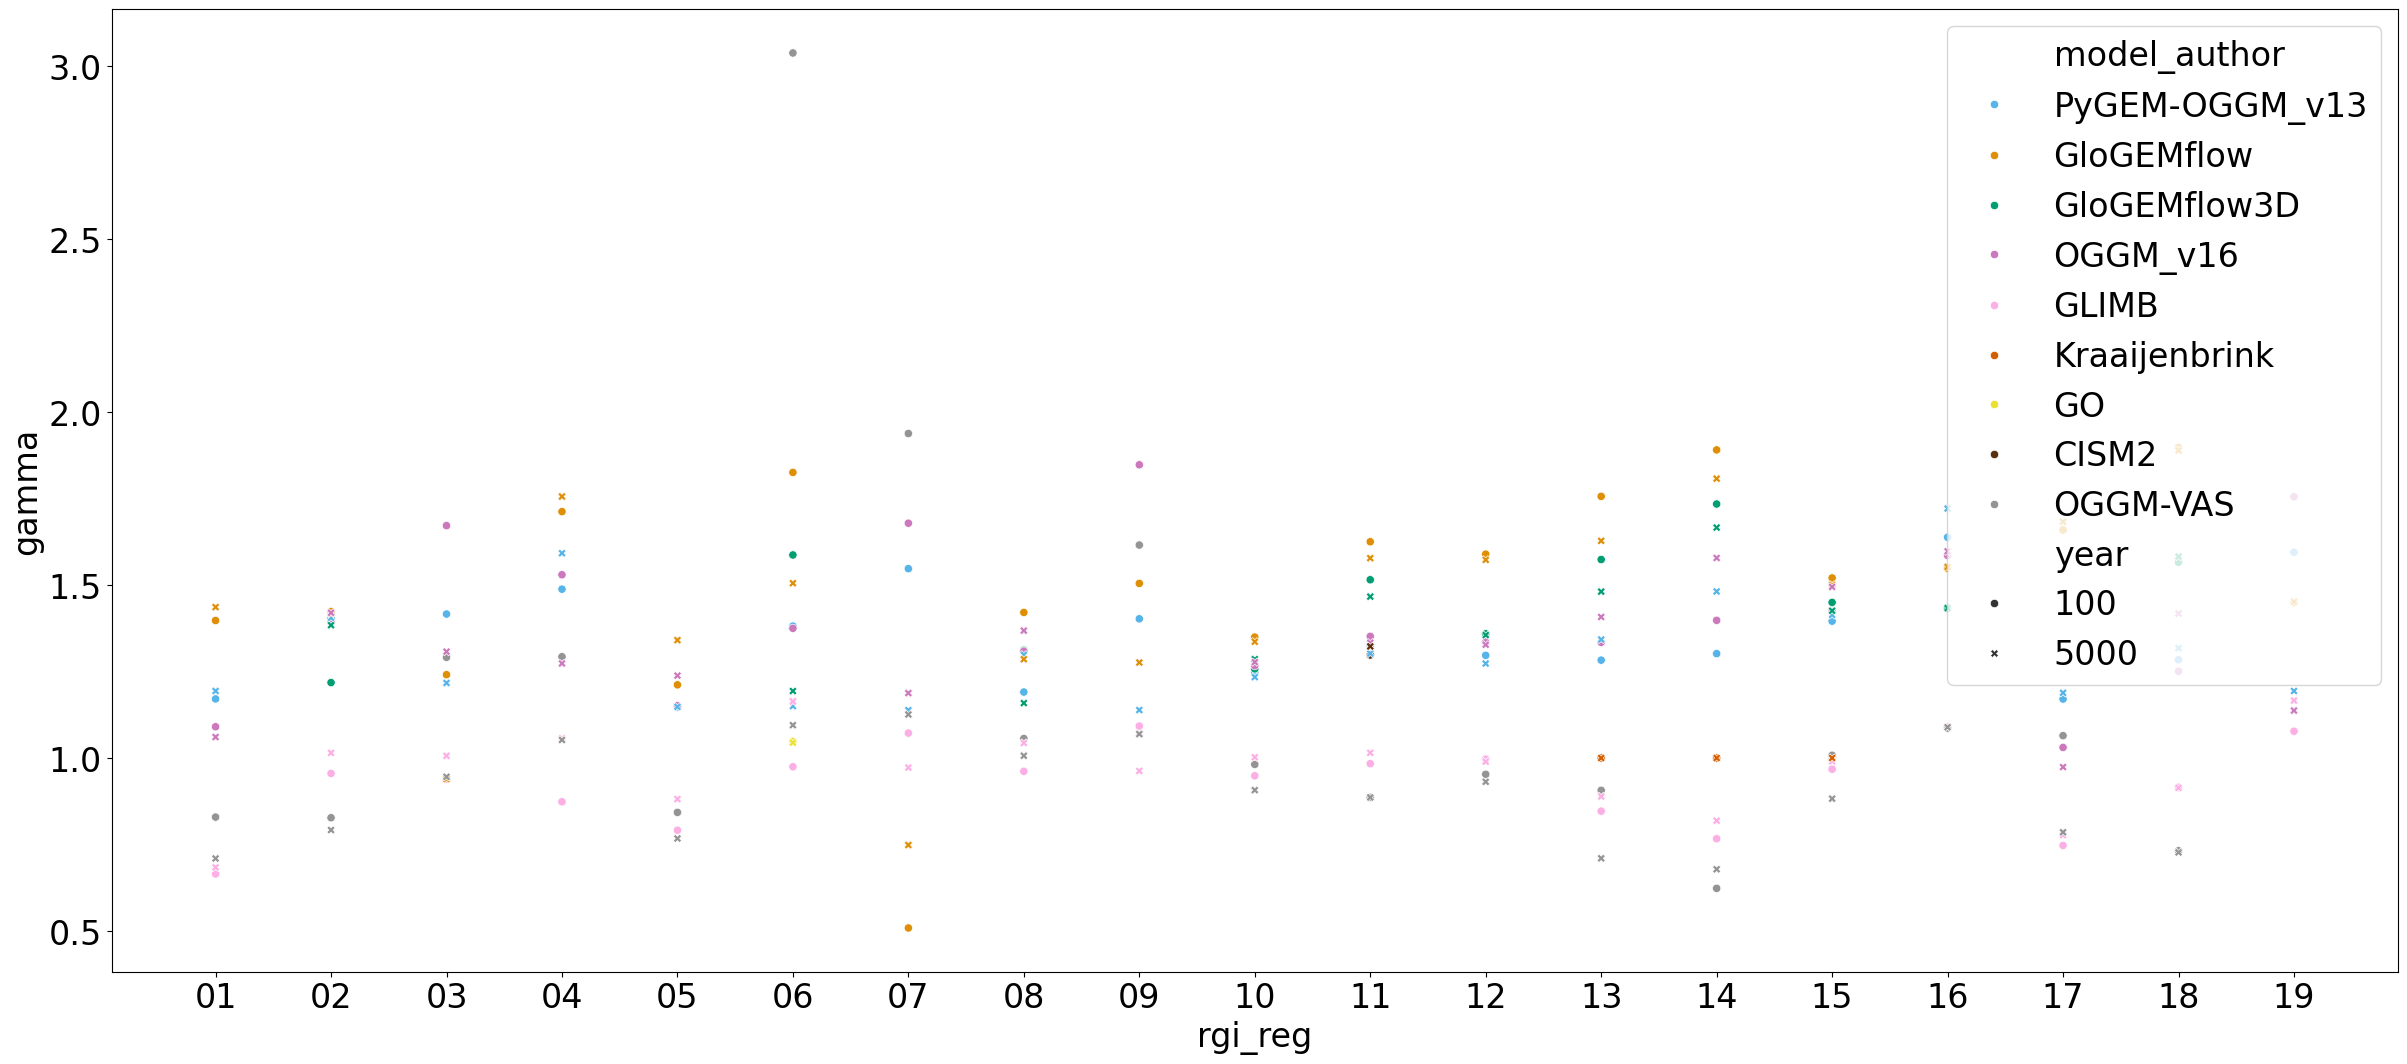

In [147]:
plt.rc('font', size=24)  
plt.figure(figsize=(29.5,12.5)) #, sharey=True)
ax=plt.gca()
#fig, axs = plt.subplots(2,1,figsize=(29.5,25), sharey=True)
sns.scatterplot(data=pd_vas, hue='model_author', y='gamma', x='rgi_reg',
                style='year',
           hue_order=hue_order, palette=pal_models, ax=ax)

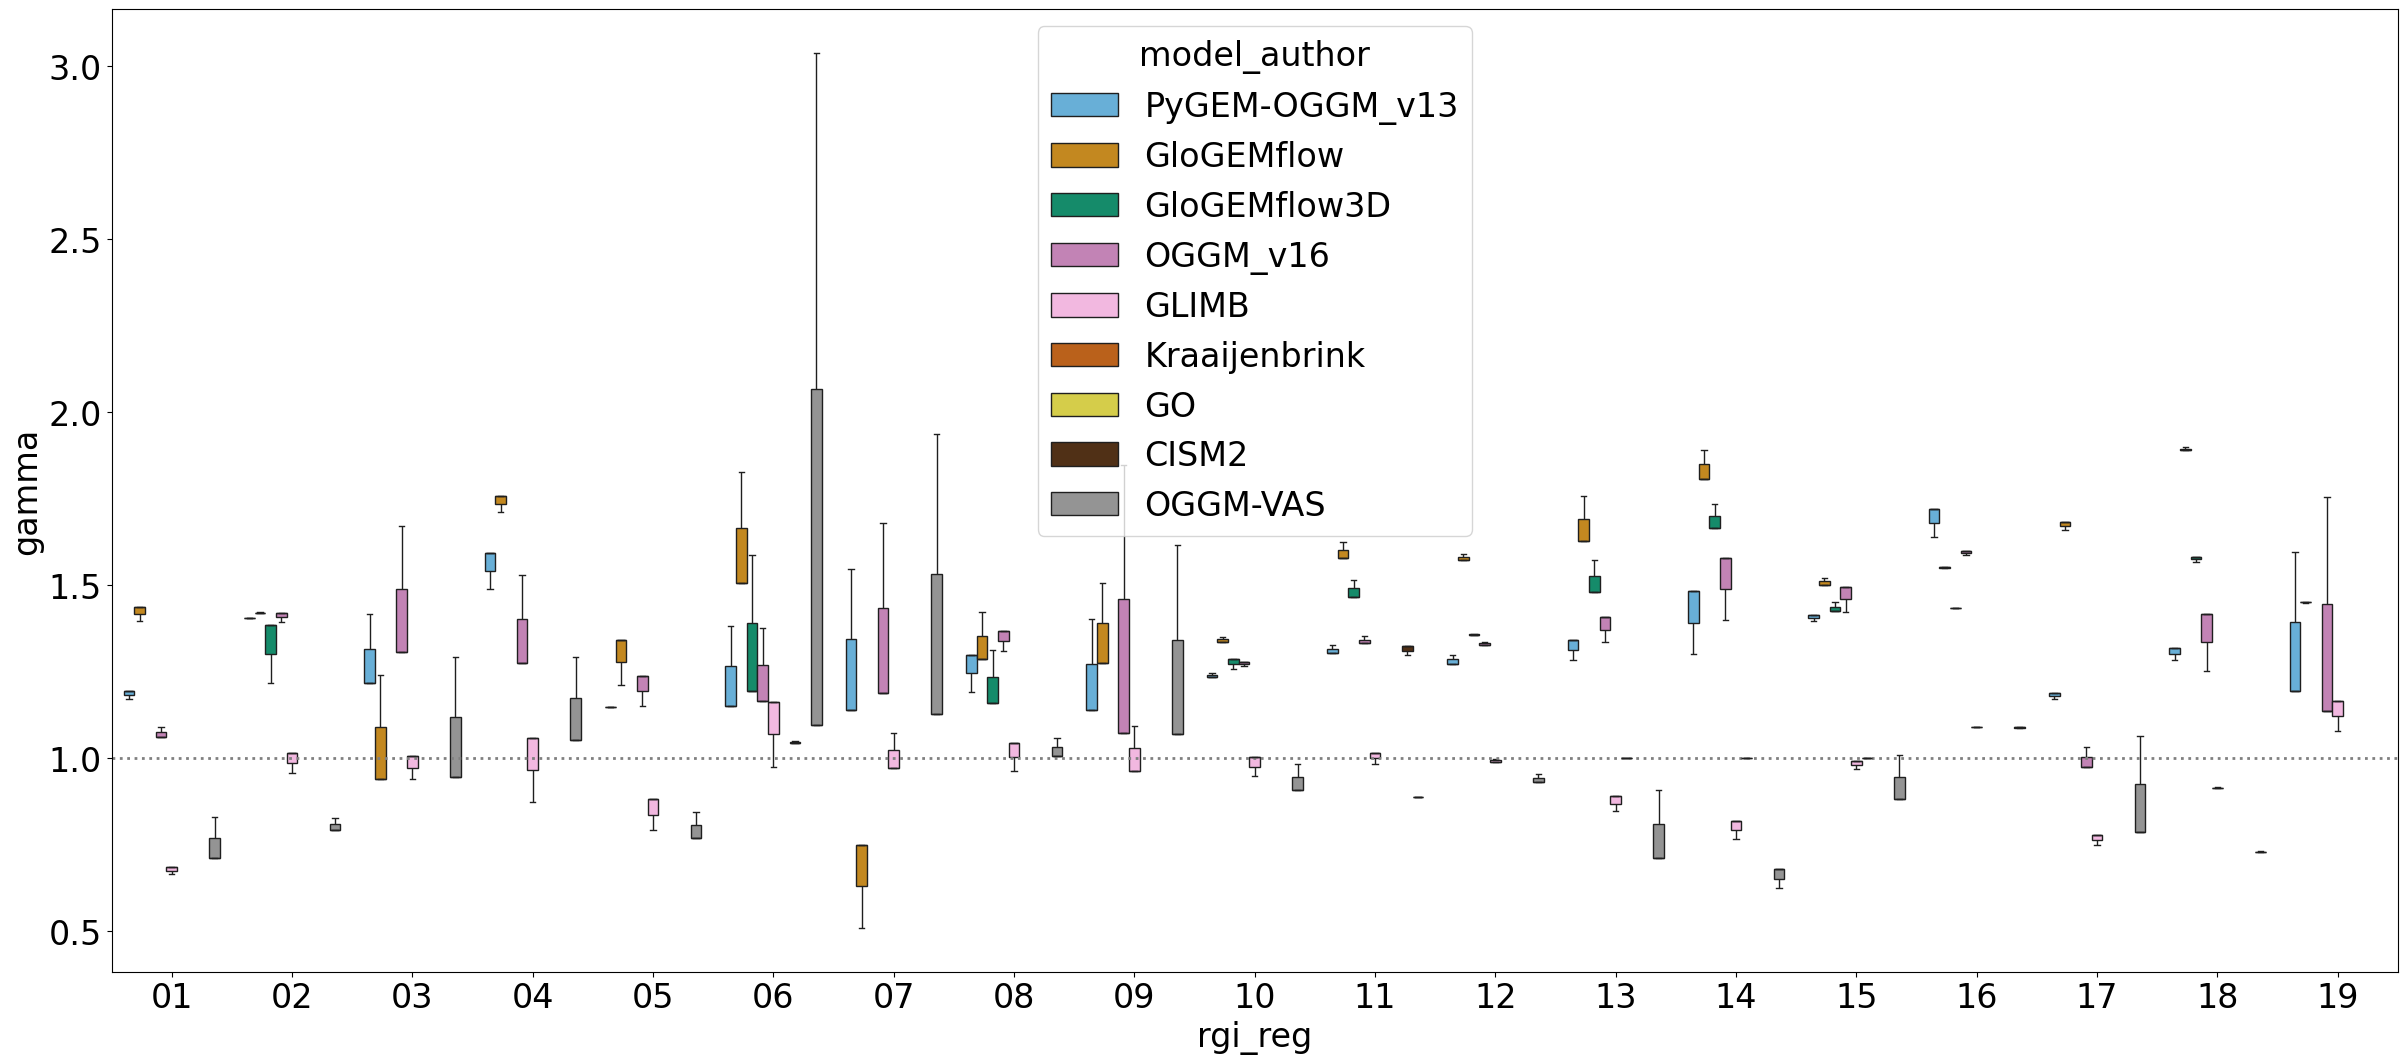

In [210]:
plt.rc('font', size=24)  
plt.figure(figsize=(29.5,12.5)) #, sharey=True)
ax=plt.gca()
#fig, axs = plt.subplots(2,1,figsize=(29.5,25), sharey=True)
sns.boxplot(data=pd_vas, hue='model_author', y='gamma', x='rgi_reg',
           hue_order=hue_order, palette=pal_models, ax=ax)
ax.axhline(1,lw=2,ls=':', color='grey')

<AxesSubplot:xlabel='rgi_reg', ylabel='r2'>

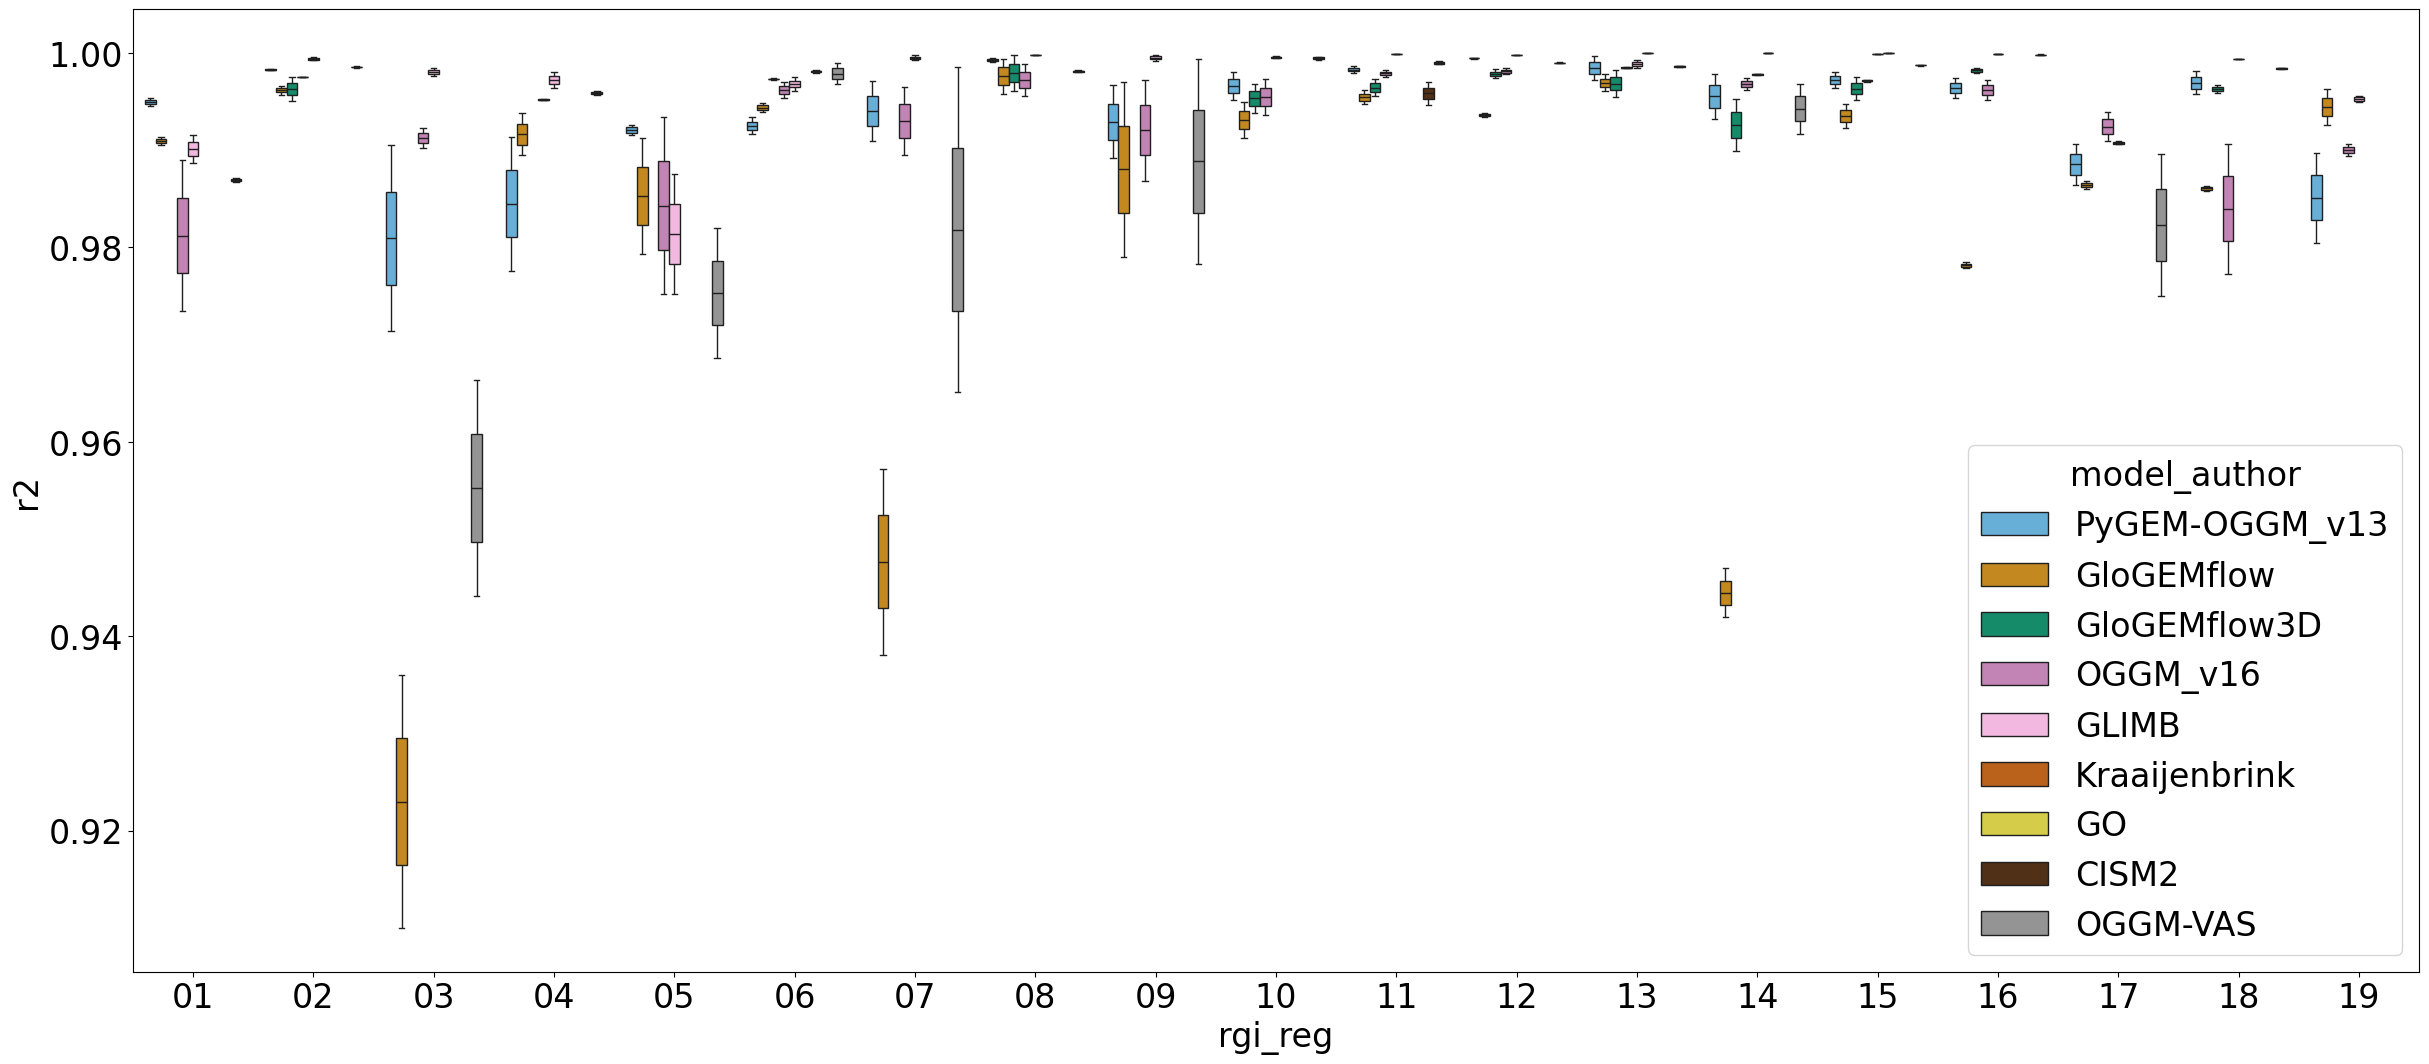

In [142]:
plt.rc('font', size=24)  
plt.figure(figsize=(29.5,12.5)) #, sharey=True)
ax=plt.gca()
#fig, axs = plt.subplots(2,1,figsize=(29.5,25), sharey=True)
sns.boxplot(data=pd_vas, hue='model_author', y='r2', x='rgi_reg',
           hue_order=hue_order, palette=pal_models, ax=ax)

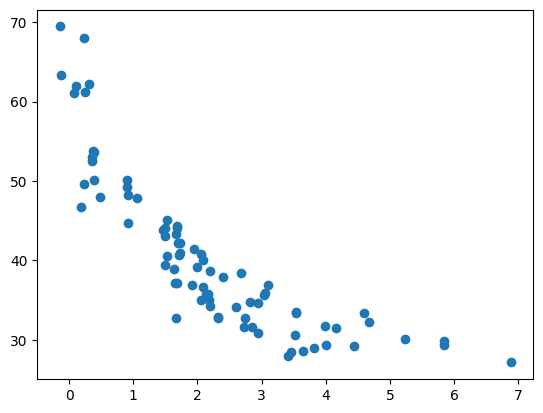

In [39]:
plt.plot(ds_stack.temp_ch_ipcc.sel(experiments=_ds_vol.experiments), _ds_vol/_ds_area, 'o')